Fracture
=========

This example demonstrates constructing a lattice from a custom unit cell to simulate fracture in a two-dimensional elastic sheet.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/tjsego/mechanica-binder/HEAD?filepath=notebooks%2Fsolid_mech_fracture.ipynb)

Basic Setup
------------

Begin by initializing Mechanica with a quasi-two-dimensional simulation domain. 

In [1]:
import math
import mechanica as mx

mx.init(dim=[40, 20, 3])

Particle Types
---------------

Declare a particle type to represent parcels of solid material, and generate two sub-types, 

1. for applying a constraint of zero displacement along the ``y``-direction, and 
2. for applying an external load along the ``y``-direction.

In [2]:
class MtlType(mx.ParticleType):
    """Basic material type"""

    radius = 0.1


class BoundaryType(MtlType):
    """Material type with a zero-displacement condition along ``y``"""

    style = {'color': 'orange'}

    @staticmethod
    def apply_boundary(p: mx.ParticleHandle):
        p.frozen_y = True


class LoadedType(MtlType):
    """Material type on which an external load is applied"""

    style = {'color': 'darkgreen'}


mtl_type = MtlType.get()
boundary_type = BoundaryType.get()
loaded_type = LoadedType.get()

Lattice Construction
---------------------

Construct a ``60x20`` lattice of square unit cells with mid-point and center-point particles for a given lattice constant. Add bonds with Hookean potentials to all neighboring particles within a Manhattan distance of one, where the rest length of each bond corresponds to the distance between its two particles. Make all particles in the unit cell of the basic material type. 

In [3]:
n_lattice = [60, 20]
a = 6 * mtl_type.radius
stiffness = 1E2
pot_border = mx.Potential.harmonic(k=stiffness, r0=a/2)
pot_cross = mx.Potential.harmonic(k=stiffness, r0=a/2*math.sqrt(2))
bcb_border = lambda i, j: mx.Bond.create(pot_border, i, j)
bcb_cross = lambda i, j: mx.Bond.create(pot_cross, i, j)

uc_sqcross = mx.lattice.unitcell(N=4,
                                 types=[mtl_type] * 4,
                                 a1=[a, 0, 0],
                                 a2=[0, a, 0],
                                 a3=[0, 0, 1],
                                 dimensions=2,
                                 position=[[0,     0, 0],
                                           [a/2,   0, 0],
                                           [0,   a/2, 0],
                                           [a/2, a/2, 0]],
                                 bonds=[
                                     mx.lattice.BondRule(bcb_border, (0, 1), (0, 0, 0)),
                                     mx.lattice.BondRule(bcb_border, (0, 2), (0, 0, 0)),
                                     mx.lattice.BondRule(bcb_cross,  (0, 3), (0, 0, 0)),
                                     mx.lattice.BondRule(bcb_cross,  (1, 2), (0, 0, 0)),
                                     mx.lattice.BondRule(bcb_border, (1, 3), (0, 0, 0)),
                                     mx.lattice.BondRule(bcb_border, (2, 3), (0, 0, 0)),
                                     mx.lattice.BondRule(bcb_border, (1, 0), (1, 0, 0)),
                                     mx.lattice.BondRule(bcb_cross,  (1, 2), (1, 0, 0)),
                                     mx.lattice.BondRule(bcb_cross,  (3, 0), (1, 0, 0)),
                                     mx.lattice.BondRule(bcb_border, (3, 2), (1, 0, 0)),
                                     mx.lattice.BondRule(bcb_border, (2, 0), (0, 1, 0)),
                                     mx.lattice.BondRule(bcb_cross,  (2, 1), (0, 1, 0)),
                                     mx.lattice.BondRule(bcb_cross,  (3, 0), (0, 1, 0)),
                                     mx.lattice.BondRule(bcb_border, (3, 1), (0, 1, 0)),
                                     mx.lattice.BondRule(bcb_cross,  (3, 0), (1, 1, 0)),
                                     mx.lattice.BondRule(bcb_cross,  (2, 1), (-1, 1, 0))
                                 ])

parts = mx.lattice.create_lattice(uc_sqcross, n_lattice)

Loading Boundary Conditions
----------------------------

Construct a list of the row of particles nearest to the Front face (``-y``) of the simulation domain, and another list of the two rows of particles nearest to the Back face (``+y``) of the simulation domain. Make the particles near the Front face of the particle type with the displacement constraint, and make the particles near the Back face of the particle type with the external load. 

In [4]:
p_back, p_front = [], []
for i in range(2):
    p_front.extend([p[i] for p in parts[:, 0, :].flatten().tolist()])
for i in range(4):
    p_back.extend([p[i] for p in parts[:, n_lattice[1]-1, :].flatten().tolist()])

# Apply types

for p in p_front:
    p.become(boundary_type)
    BoundaryType.apply_boundary(p)
for p in p_back:
    p.become(loaded_type)

Fracture Criterion
-------------------

If the dissociation energy of a bond is set, then the bond automatically breaks when its potential energy exceeds the dissociation energy. Apply a fracture criterion to bonds between particles of the basic material type by assigning a dissocation energy. 

In [5]:
mtl_ids = [p.id for p in mtl_type.parts]
for p in mtl_type.items():
    for b in p.bonds:
        p1id, p2id = b.parts
        if p1id in mtl_ids and p2id in mtl_ids:
            b.dissociation_energy = 1E-2

External Loading
-----------------

Apply a constant force to the particle type for external loading along the ``+y`` direction, as well as damping using a friction force. 

In [6]:
f_load = mx.ConstantForce([0, 2, 0])
f_friction = mx.Force.friction(coef=1000.0)
mx.bind.force(f_load + f_friction, loaded_type)

0

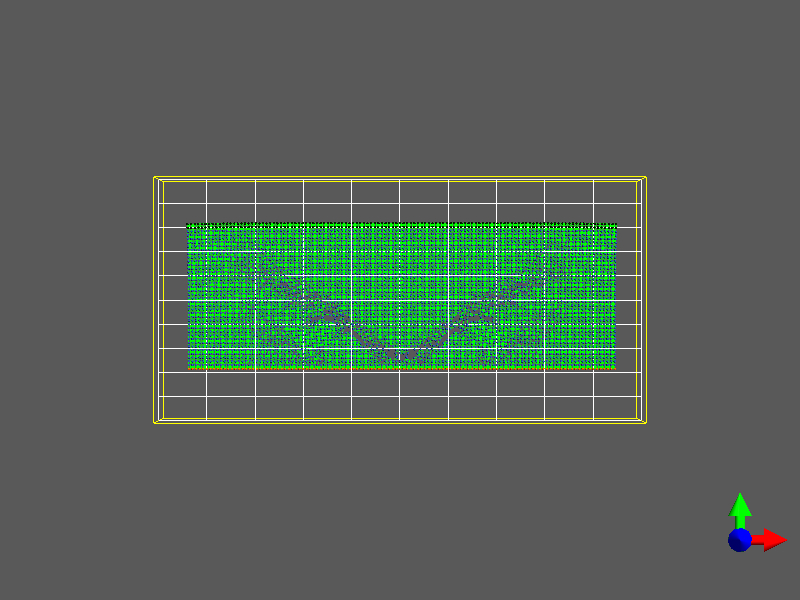

In [7]:
mx.system.cameraViewTop()
mx.show()